In this notebook I analyse the age distribution of the local area, and compare it to Wales as a whole. The data is at the LSOA level. What we find is that the area in which SRCDC works is one of the younger parts of Wales. In particular, there are very few people over the age of 65. 

This data comes from https://statswales.gov.wales/Catalogue/Population-and-Migration/Population/Estimates/Small-Area/populationestimates-by-lowersuperoutputarea-agegroup

In [1]:
import numpy as np
import pandas as pd

Here we make a list of the LSOA codes that are around SRCDC. 

In [2]:
grangetown_codes = ['W01001759','W01001760','W01001761','W01001762','W01001764','W01001765',\
                    'W01001766','W01001767','W01001768','W01001946']
canton_codes = ['W01001709', 'W01001710', 'W01001711', 'W01001712', 'W01001713', 'W01001714',\
                'W01001715', 'W01001716', 'W01001717'] 
riverside_codes = ['W01001855', 'W01001856', 'W01001857', 'W01001862']
lsoa_codes = np.concatenate([grangetown_codes, canton_codes, riverside_codes])

This is the dictionary that converts the LSOA names in the data to the LSOA codes that we use more often. 

In [3]:
lsoa_name_to_code_dict = np.load("../utilities/name_to_code_dict.npy").item(0)

Getting the data ready for analysing. Need to skip some rows, rename some columns, and some get the place names to match what my place names dictionary has. Also added the LSOA code and a true/false column indicating whether the LSOA is local or not. 

In [4]:
file = 'age.xlsx'
data = pd.read_excel(file,skiprows=1)
data = data.drop(columns=['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'])
data = data.drop([0,1,2,3])
data = data.rename(columns={'Unnamed: 8': 'Total','Unnamed: 4': 'LSOA name'})
data = data.dropna()
data['LSOA name'] =  list(map(lambda lsoa_name : lsoa_name.strip(), data['LSOA name']))
data['LSOA name'] =  list(map(lambda lsoa_name : lsoa_name.replace("Rhydfelen Central / Llan ","Rhydfelen Central/Ilan "), data['LSOA name']))
data['LSOA code'] =  list(map(lambda lsoa_name : lsoa_name_to_code_dict[lsoa_name], data['LSOA name']))
data = data.set_index('LSOA code')
data['local'] = list(map(lambda lsoa : int(np.isin(lsoa,lsoa_codes)), data.index.values))

This is a function for plotting the above data, separating out the local and non-local LSOAs. It can also pick out local LSOAs in the top nth percentiles, using the percentile option. To find LSOAs in the bottom nth percentile, use percentile = -n. Percentile option only works if plotting a bar chart. The bar chart will plot the top or bottom n percentiles of the LSOAs.

In [5]:
def plot_two_data_sets(stat,data,stat2=None,kind='bar',figsize=(15,7),percentile=10.0): 
    if kind == 'bar':
        percentile/=100.
        order = data[stat].dropna().sort_values().keys()
        lnl_data = pd.concat([data[data['local']==True][stat],data[data['local']==False][stat]],\
                                                             axis=1,keys=['local','non-local'])
        if percentile>0:
            lnl_data.set_index(lnl_data.index.values).loc[order[-int(len(data)*percentile):]].plot(\
                                                                kind=kind,title=stat,figsize=figsize)
            return [code for code in order[-int(len(data)*percentile):] if data['local'][code]==True ]
        else:
            lnl_data.set_index(lnl_data.index.values).loc[order[:-int(len(data)*percentile)]].plot(\
                                                                kind=kind,title=stat,figsize=figsize)
            return [code for code in order[:-int(len(data)*percentile)] if data['local'][code]==True ]

    elif kind == 'scatter':
        data.plot.scatter(x=stat, y=stat2,c='local',colormap='viridis',figsize=figsize)
    else:
        lnl_data = pd.concat([data[data['local']==True][stat],data[data['local']==False][stat]],\
                             axis=1,keys=['local','non-local'])
        lnl_data.plot(kind=kind,title=stat,figsize=figsize)


Below we plot the top 1% of LSOAs for number of people in each age group.

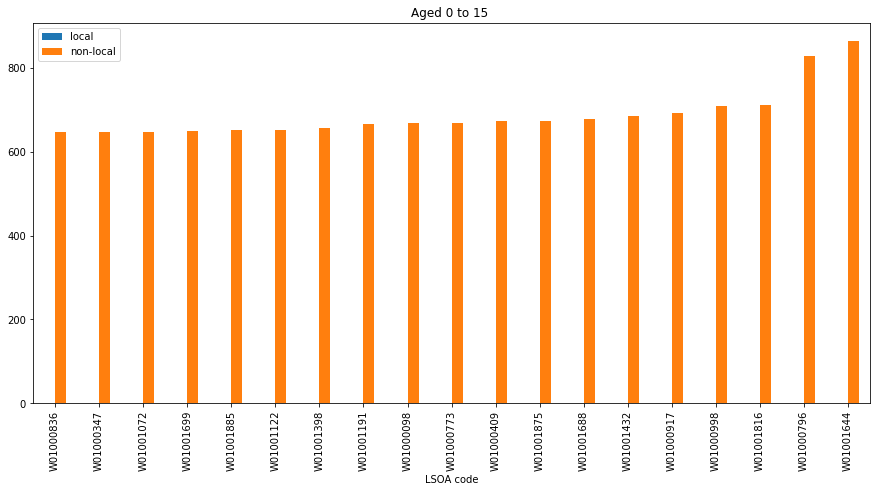

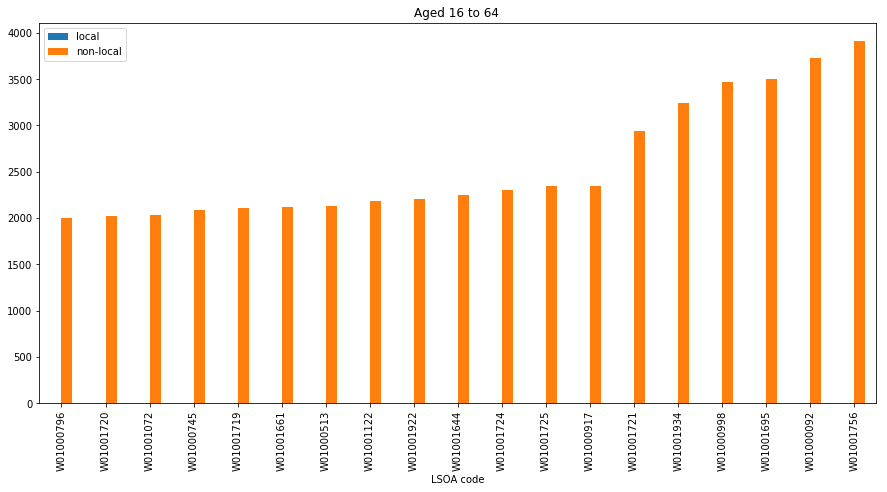

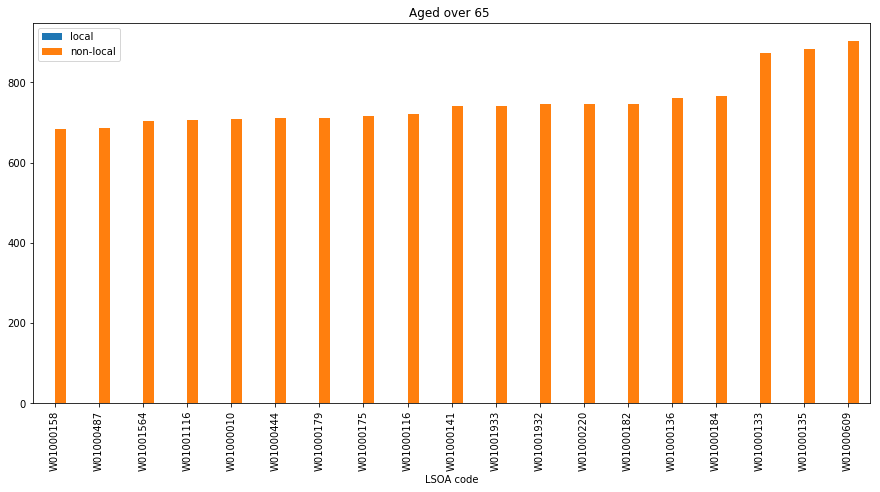

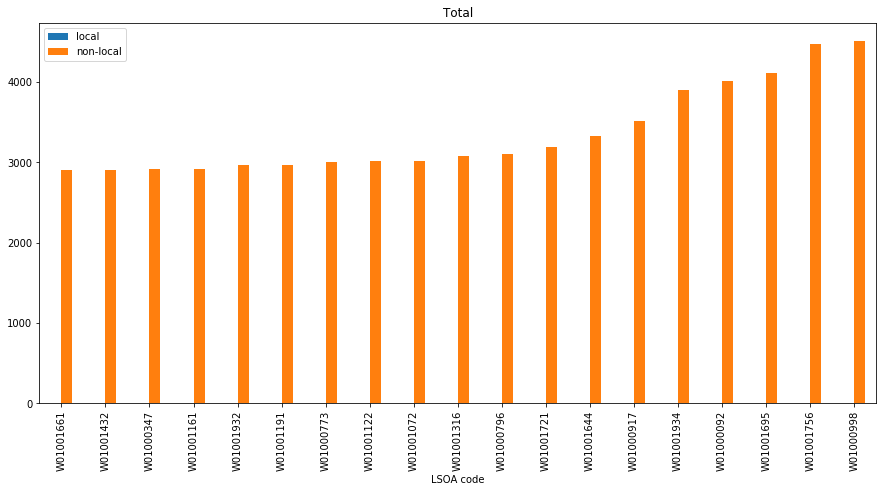

In [13]:
top_1pc_local = {}
for stat in data.drop(columns=['LSOA name','local']).keys():
    top_1pc_local[stat] = plot_two_data_sets(stat=stat,data=data,kind='bar',percentile=1.0)

Below we plot the top 10% of LSOAs for number of people in each age group.

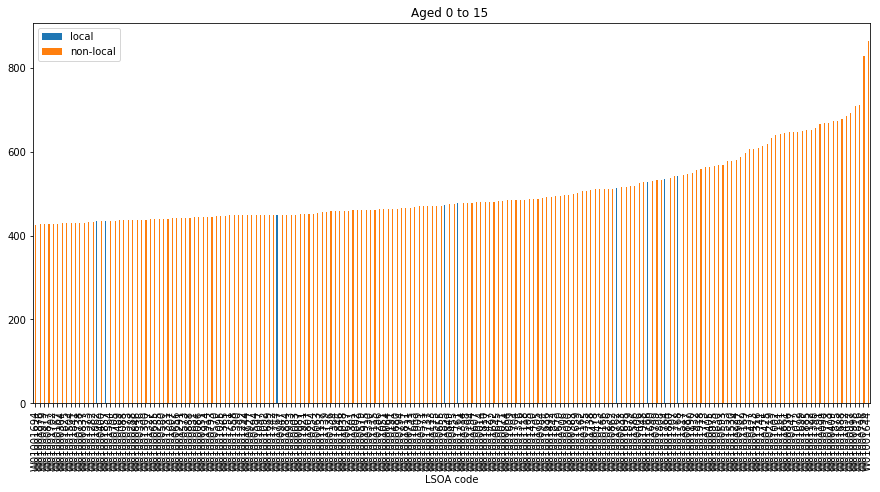

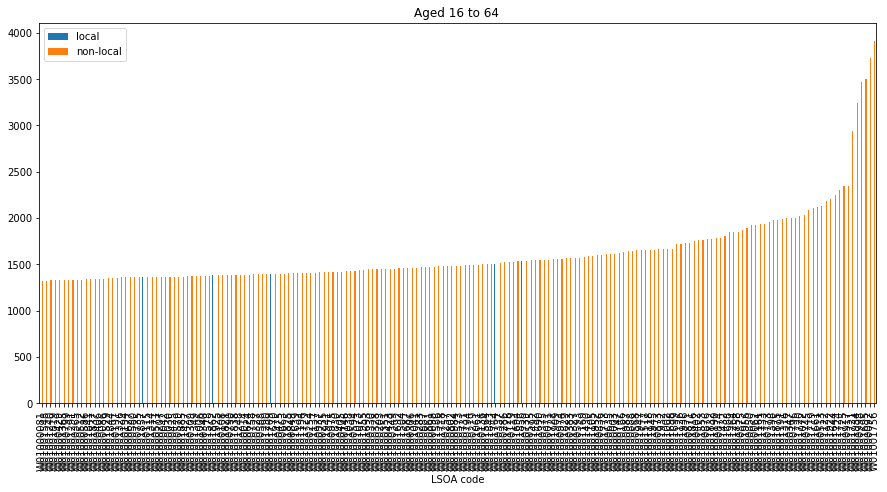

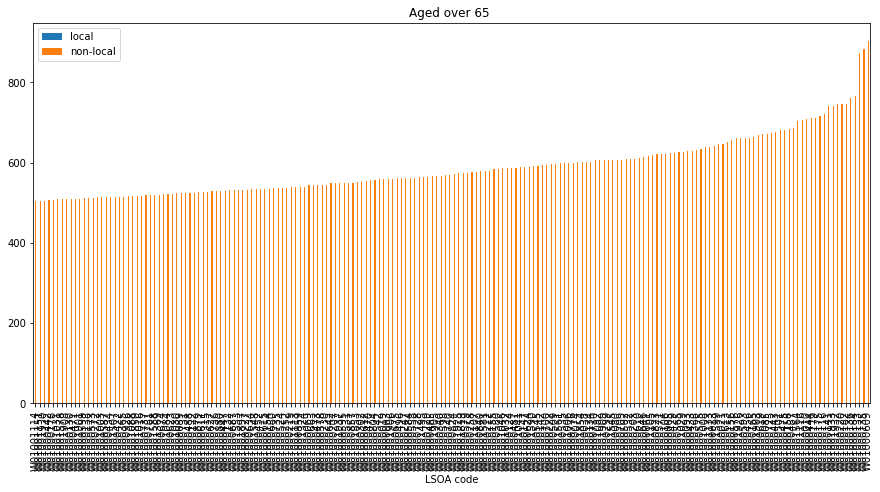

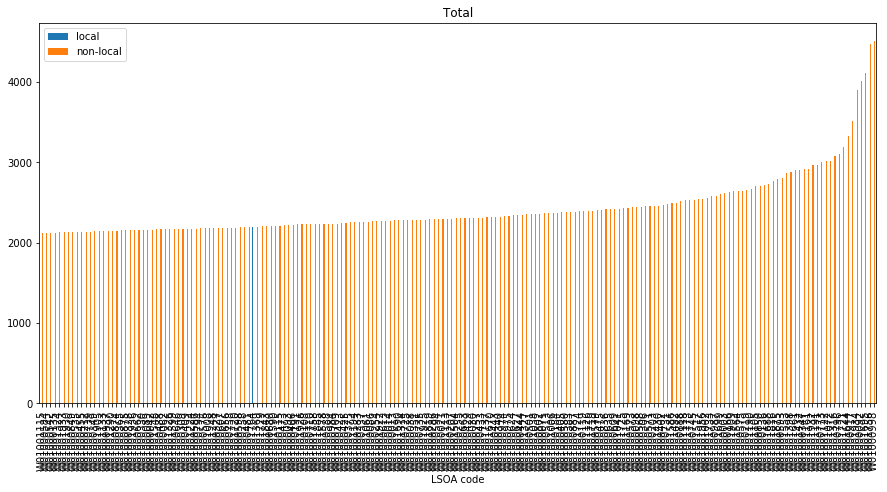

In [7]:
top_10pc_local = {}
for stat in data.drop(columns=['LSOA name','local']).keys():
    top_10pc_local[stat] = plot_two_data_sets(stat=stat,data=data,kind='bar',percentile=10.0)

Now we look at the number of local LSOAs in the top 10 percentiles and top 1 percentile for each age group>

In [8]:
top_10pc_count = {key : len(top_10pc_local[key]) for key in top_10pc_local.keys()}
top_1pc_count = {key : len(top_1pc_local[key]) for key in top_1pc_local.keys()}
top_10pc_count_df = pd.DataFrame.from_dict(top_10pc_count, orient='index')
top_1pc_count_df = pd.DataFrame.from_dict(top_1pc_count, orient='index')
top_1_10_pc_df = pd.concat([top_10pc_count_df,top_1pc_count_df],axis=1,keys=['10 pc','1 pc'])
top_1_10_pc_df

,10 pc,1 pc
,0,0
Aged 0 to 15,9,0
Aged 16 to 64,5,0
Aged over 65,0,0
Total,1,0


And now we plot this data.

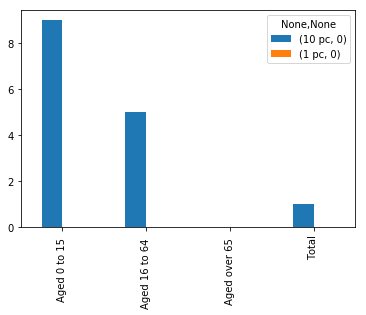

In [9]:
top_1_10_pc_df.plot(kind='bar')

The above analysis was looking at extreme values (the top 10 and 1 percentiles). Below we make box plots of the data to get a feel for the distribution of the data. 

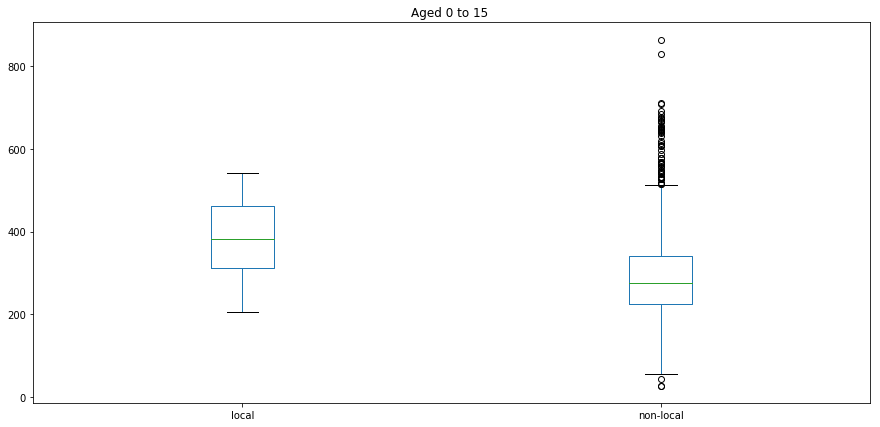

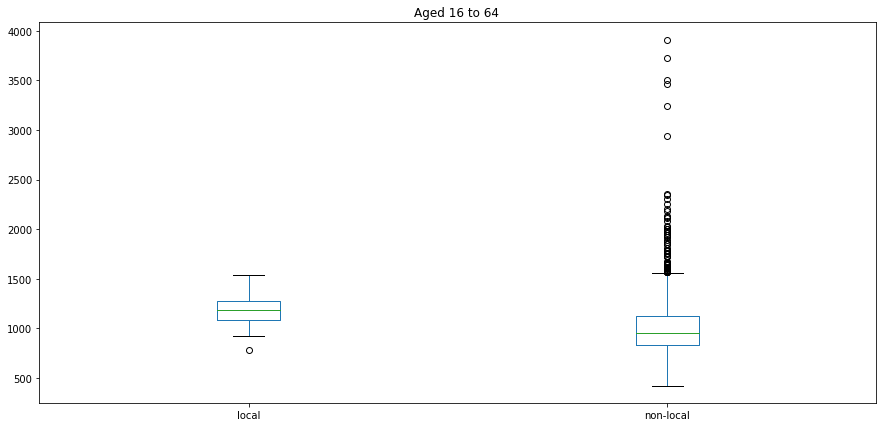

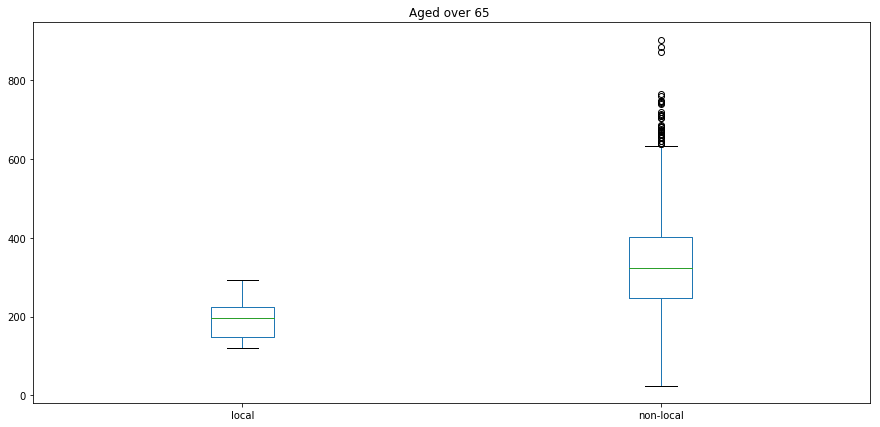

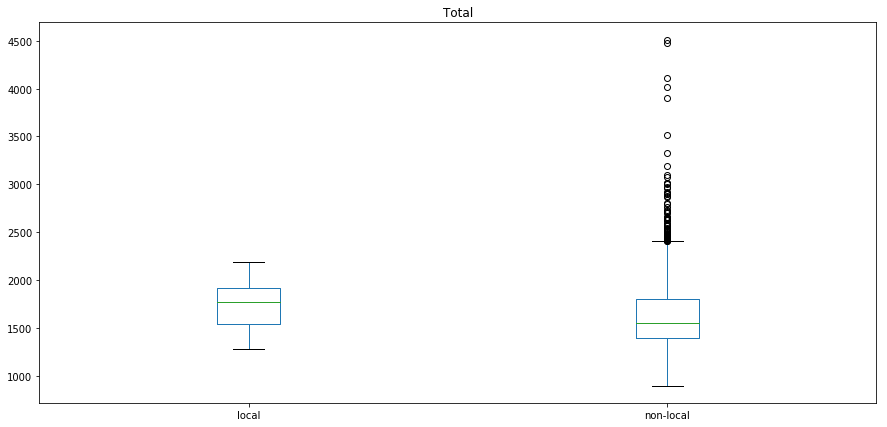

In [10]:
for stat in data.drop(columns=['LSOA name','local']).keys():
    plot_two_data_sets(stat=stat,data=data,kind='box')

The box plots suggest we have relatively few people over the age of 65 in the local area. Below we plot the bottom 10 percentiles for age, and we can see that the local area is quite unusual in how few people there are over 65. Of the 23 local LSOAs, 11 of them are in the bottom 10 percentiles for number of people of age 65+. 

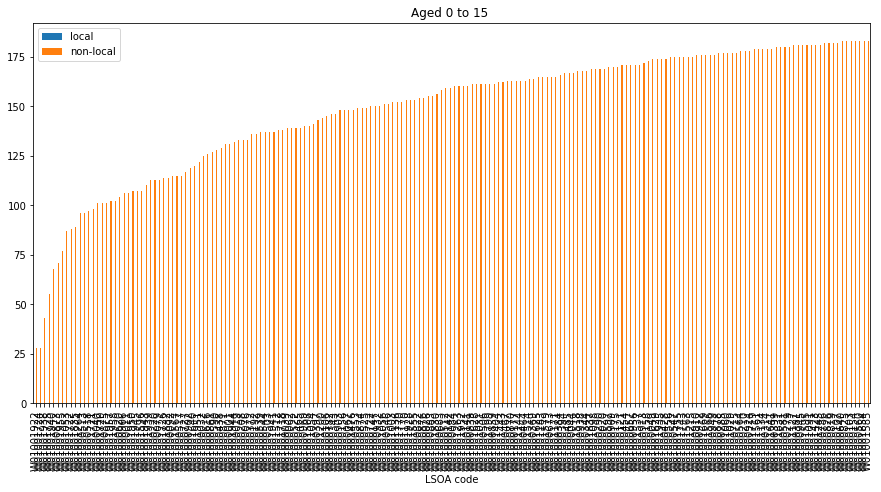

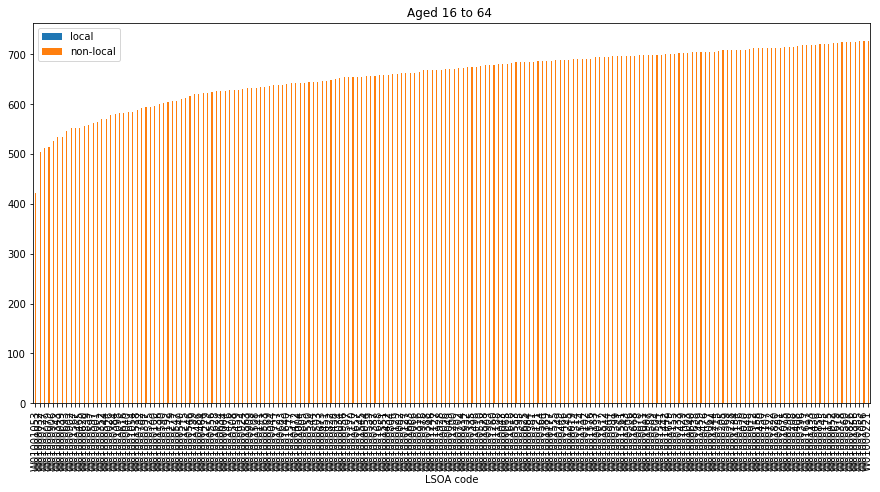

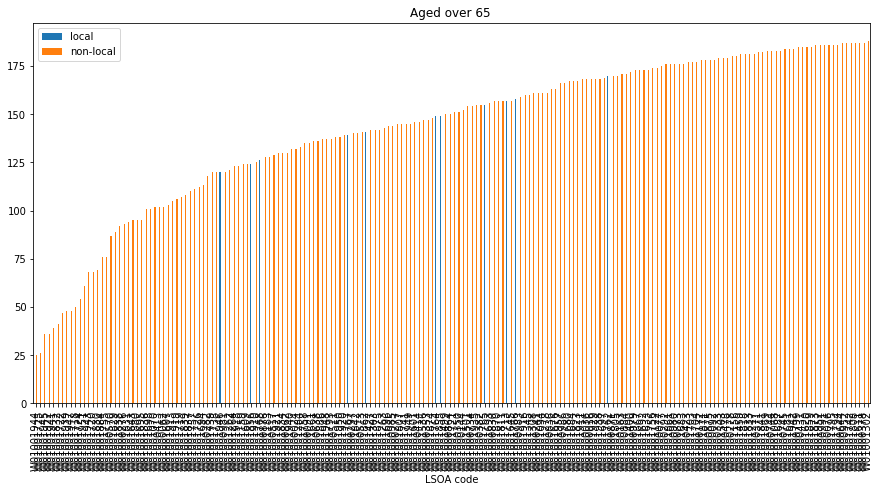

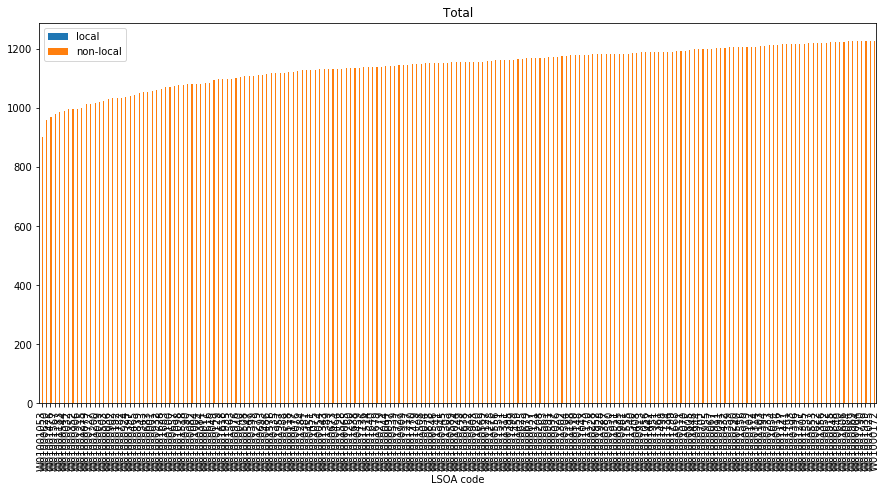

In [11]:
bottom_10pc_local = {}
for stat in data.drop(columns=['LSOA name','local']).keys():
    bottom_10pc_local[stat] = plot_two_data_sets(stat=stat,data=data,kind='bar',percentile=-10.0)

In [12]:
bottom_10pc_count = {key : len(bottom_10pc_local[key]) for key in bottom_10pc_local.keys()}
bottom_10pc_count

{'Aged 0 to 15 ': 0, 'Aged 16 to 64 ': 0, 'Aged over 65 ': 11, 'Total': 0}